In [1]:
# Google Colab, clone the repository for helper functions
%rm -rf * && rm -rf .*
!git clone https://github.com/Asheeshkrsharma/Identification-OpenCows.git .

rm: refusing to remove '.' or '..' directory: skipping '.'
rm: refusing to remove '.' or '..' directory: skipping '..'
Cloning into '.'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 242 (delta 13), reused 23 (delta 8), pack-reused 213
Receiving objects: 100% (242/242), 512.60 MiB | 21.31 MiB/s, done.
Resolving deltas: 100% (90/90), done.
Checking out files: 100% (45/45), done.


In [1]:
# !pip3 install hiddenlayer
# !pip3 install tqdm

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torchvision.models as models
import hiddenlayer as hl
from tqdm import tqdm
from torch import optim
import numpy
from torch.utils.data import DataLoader
from utils.OpenSetCows2021 import OpenSetCows2021TrackLet

In [2]:
with tqdm(range(2), desc="Preparing dataset") as pbar:
  # Lambda function updates the tqdm progress bar.
  tqdmDescribe = lambda message, pbar: pbar.set_description(message);
  pbar.refresh()
  # The list of files is stored in the following files
  files = list(open("./utils/opencows2021.txt", "r").readlines())
  tqdmDescribe(f"Downloading OpenSetCows2021 ({len(files)} files from data.bris.ac.uk)", pbar)
  # This downloads a 500 files concurrently using wget. (takes roughly 2 minutes)
  %rm -rf datasets && cat ./utils/opencows2021.txt | xargs -n 500 -P 8 wget -x -nH -q
  pbar.update()
  tqdmDescribe(f"Organizing dataset", pbar)
  %mkdir -p datasets/OpenSetCows2021
  %mv -f ./datasets/*/Sub-levels ./datasets/OpenSetCows2021/ 2>/dev/null
  %rm -rf ./datasets/4vnrca7qw1642qlwxjadp87h7
  pbar.update()

Organizing dataset: 100%|██████████| 2/2 [05:08<00:00, 154.33s/it]


In [2]:
class ResNetMod(nn.Module):
    def __init__(self, numClasses, embeddingSize=128):
        """Initialize the model

        Parameters
        ----------
        numClasses : Int
            Number of classes (or individuals in a dataset)
        embeddingSize : Int, optional
            Size of the final embedding used differentiate individuals

        Returns
        -------
        A ResNetMod class instance
        """
        super(ResNetMod, self).__init__()

        # We create a resnet50 block and load imagenet weight into it
        self.backbone = models.resnet50(pretrained=True)
        imagenetWeights = model_zoo.load_url(
            "https://download.pytorch.org/models/resnet50-19c8e357.pth"
        )
        self.backbone.load_state_dict(imagenetWeights)

        # These layers are trained again, bias is set to true.
        self.backbone.fc = nn.Linear(2048, 1000)
        self.relu = nn.ReLU(inplace=True)
        # self.embedding = nn.Linear(1000, embeddingSize)
        # self.softmax = nn.Linear(1000, numClasses)

    def forwardOnce(self, x):
        """Forward through the network once

        Parameters
        ----------
        x : Input image to embed
            [Batch Size, Channel, Width, Height]

        Returns
        -------
        Embedding
            [Batch Size, 128]
        Softmax
            [Batch Size, Num Classes]
        """

        # Conv1 -> Relu(bn1) -> maxpool
        x = self.backbone.maxpool(
            self.backbone.relu(self.backbone.bn1(self.backbone.conv1(x)))
        )
        # avgpool(Layer 1 -> Layer 2 -> Layer 3 -> Layer 4)
        x = self.backbone.avgpool(
            self.backbone.layer4(
                self.backbone.layer3(self.backbone.layer2(
                    self.backbone.layer1(x))
                )
            )
        )
        # Relu(FC)
        x = self.relu(self.backbone.fc(x.view(x.size(0), -1)))
        # return self.embedding(x), self.softmax(x)
        # return self.embedding(x)
        return x

    def forward(self, anchor, negative=None, positive=None):
        """Forward the network

        Parameters
        ----------
        anchor : Input image to embed
            [Batch Size, Channel, Width, Height]
        negative : Input image, optional
            [Batch Size, Channel, Width, Height] used during
            training with Triplet loss
        positive : Input image, optional
            [Batch Size, Channel, Width, Height] used during
            training with Triplet loss

        Returns
        -------
        list
            Embeddings and softmax ouputs for negative, anchor,
            and postive triplets in case nagative and postive
            image inputs are provided. Otherwise, returns a
            single embedding and softmax output.
        """
        if (negative != None) & (positive != None):
            negativeEMBD = self.forwardOnce(negative)
            anchorEMBD = self.forwardOnce(anchor)
            positiveEMBD = self.forwardOnce(positive)
            return (
                negativeEMBD,
                anchorEMBD,
                positiveEMBD,
            )
        else:
            anchorEMBD = self.forwardOnce(anchor)
            return anchorEMBD

    def __repr__(self):
        summary = \
        f"{self.backbone.conv1.__repr__()} \n{self.backbone.bn1.__repr__()}"
        summary += "\nResnet Backbone: \n"
        layers = [
            self.backbone.layer1,
            self.backbone.layer2,
            self.backbone.layer3,
            self.backbone.layer4,
        ]
        for layer in layers:
            parameters = list(layer.named_parameters())
            summary += (
                f"\t ⎣ Input: {list(parameters[0][1].size())}"
                + f" -> Output: {list(parameters[-1][1].size())} ↩\n"
            )
        summary += self.backbone.fc.__repr__()
        summary += "\nOutput 1: " + self.embedding.__repr__()
        summary += "\nOutput 2: " + self.softmax.__repr__()
        return summary


In [4]:
class Lstm(nn.Module):
    def __init__(self, inputSize, embeddingSize):
        super(Lstm, self).__init__()
        self.Lstm = torch.nn.LSTM(input_size=inputSize,
                                  hidden_size=embeddingSize,
                                  num_layers=1, batch_first=True)
        self.hidden_state = None

    def reset_hidden_state(self):
        self.hidden_state = None

    def forward(self,x):
        output, self.hidden_state = self.Lstm(x, self.hidden_state)
        return output, self.hidden_state

class LRResNetMod(nn.Module):
    def __init__(self, numClasses, embeddingSize=128):
        super(LRResNetMod, self).__init__()
        
        # We create a resnet50 block and load imagenet weight into it
        self.backbone = models.resnet50(pretrained=True)
        imagenetWeights = model_zoo.load_url(
            "https://download.pytorch.org/models/resnet50-19c8e357.pth"
        )
        self.backbone.load_state_dict(imagenetWeights)

        # These layers are trained again, bias is set to true.
        self.backbone.fc = nn.Linear(2048, 1000)
        self.relu = nn.ReLU(inplace=True)

        # self.ResnetMod.load_state_dict(
        #     torch.load("models/RTLSL_67-33_98.2.pth", map_location=torch.device("cpu"))
        # )
        # for param in self.ResnetMod.parameters():
        #   param.requires_grad = False
        self.lstm = Lstm(1000, 512)
        self.embedding = nn.Linear(512, embeddingSize)
        self.softmax = nn.Linear(512, numClasses)
    def forwardOnce(self, x):
        # x has the following shape: 
        # [
        #     Batch,
        #     sequence length (needs to be same for accross the batch,
        #     dynamic batching will be add later),
        #     channel,
        #     image height, image width
        # ]
        batch, timesteps, channels, h, w = x.shape
        x = x.view(batch * timesteps, channels, h, w)
        # x = self.ResnetMod(x)

        # Conv1 -> Relu(bn1) -> maxpool
        x = self.backbone.maxpool(
            self.backbone.relu(self.backbone.bn1(self.backbone.conv1(x)))
        )

        # avgpool(Layer 1 -> Layer 2 -> Layer 3 -> Layer 4)
        x = self.backbone.avgpool(
            self.backbone.layer4(
                self.backbone.layer3(self.backbone.layer2(self.backbone.layer1(x)))
            )
        )

        # Relu(FC)
        x = self.relu(self.backbone.fc(x.view(x.size(0), -1)))

        # Batch, number of images in each sequence, embddeing size
        x = x.view(batch, timesteps, -1)
        # Must be done before you run a new batch. Otherwise the LSTM will
        # treat a new batch as a continuation of a sequence
        self.lstm.reset_hidden_state()
        # Batch, number of images in each sequence, embddeing size
        x, _ = self.lstm(x)
        
        # print(x.shape)
        # embd = self.embedding(x[:, -1, :])

        # print(F.log_softmax(self.softmax(x).mean(dim=1)).shape)
        # Batch, numclasses
        return self.embedding(x[:, -1, :]), F.log_softmax(self.softmax(x).mean(dim=1), dim=0)

    def forward(self, anchor, negative=None, positive=None):
        """Forward the network

        Parameters
        ----------
        anchor : Input image to embed
            [Batch Size, Channel, Width, Height]
        negative : Input image, optional
            [Batch Size, Channel, Width, Height] used during
            training with Triplet loss
        positive : Input image, optional
            [Batch Size, Channel, Width, Height] used during
            training with Triplet loss

        Returns
        -------
        list
            Embeddings and softmax ouputs for negative, anchor,
            and postive triplets in case nagative and postive
            image inputs are provided. Otherwise, returns a
            single embedding and softmax output.
        """
        if (negative != None) & (positive != None):
            negativeEMBD, negativeSMax = self.forwardOnce(negative)
            anchorEMBD, anchorSMax = self.forwardOnce(anchor)
            positiveEMBD, positiveSMax = self.forwardOnce(positive)
            return (
                negativeEMBD,
                anchorEMBD,
                positiveEMBD,
                torch.cat((negativeSMax, anchorSMax, positiveSMax), 0),
            )
        else:
            anchorEMBD, anchorSMax = self.forwardOnce(anchor)
            return anchorEMBD, anchorSMax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


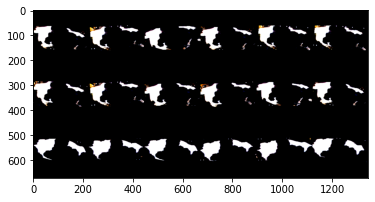

120 72


In [5]:
import matplotlib.pyplot as plt

trainingDataset = OpenSetCows2021TrackLet(
    "/content/datasets/OpenSetCows2021",
    "utils/opencowsTracklets.json",
    maxSequenceLength=6,
    transform=True,
)

# Test
negative, anchor, positive, positiveLabel, negativeLabel = trainingDataset.__getitem__(1)
anc = [a.permute(1, 2, 0).numpy() for a in anchor]
pos = [a.permute(1, 2, 0).numpy() for a in positive]
neg = [a.permute(1, 2, 0).numpy() for a in negative]

# Function to compose images in a grid
compose = lambda images, horizontal: numpy.concatenate(
    [img if horizontal == 1 else img for img in images],
    axis=horizontal,
)

plt.imshow(compose([compose(anc, 1), compose(pos, 1), compose(neg, 1)], 0))
plt.show()
print(positiveLabel, negativeLabel)


In [6]:
import torch.nn.functional as F

# Reciprocal Triplet loss
class RTL(nn.Module):
    def __init__(self):
        super(RTL, self).__init__()

    def d(self, anchor, instance):
        return (anchor - instance).pow(2).sum(1)

    def forward(self, negative, anchor, positive, prediction=None, target=None):
        return self.d(anchor, positive) + (1 / self.d(anchor, negative))

class RTLSL(nn.Module):
    def __init__(self, _lambda=0.01):
        super(RTLSL, self).__init__()
        self._lambda = _lambda
        self.RTL = RTL()
        self.CE = nn.CrossEntropyLoss()

    def forward(self, negative, anchor, positive, prediction, target):
        rtlLoss = self.RTL(negative, anchor, positive)
        entropy = self.CE(input=prediction, target=target)
        return self._lambda * rtlLoss.mean() + entropy

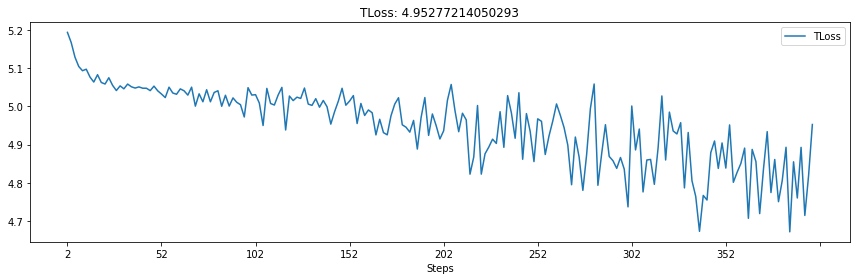

Training epochs: 100%|██████████| 400/400 [25:57<00:00,  3.89s/it]


In [7]:
trainingDataset = OpenSetCows2021TrackLet(
    "/content/datasets/OpenSetCows2021",
    "utils/opencowsTracklets.json",
    maxSequenceLength=5,
    transform=True,
)

# Get the device, prefer Cuda over CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
# There are 155 individuals in the dataset
model = LRResNetMod(155)
model.to(device)

# Working parameter (71%)
# trainingDataLoader = DataLoader(
#     trainingDataset, batch_size=5, num_workers=1, shuffle=True
# )

# optimiser = optim.SGD(model.parameters(), momentum=0.9, lr=1e-2, weight_decay=1e-7)

# Proposed parameters
trainingDataLoader = DataLoader(
    trainingDataset, batch_size=10, num_workers=1, shuffle=True
)

optimiser = optim.SGD(model.parameters(), momentum=0.9, lr=1e-2, weight_decay=1e-4)

# We will use cross entropy loss for the training
lossFN = RTLSL()

loss, numEpochs = 0, 400

# To store the training history
history, canvas = hl.History(), hl.Canvas()

with tqdm(range(numEpochs), desc="Training epochs", position=0) as pbar:
    pbar.refresh()
    # Start training
    model.train()
    for epoch in range(numEpochs):
        # Prepare a batch of 5 sequences with 10 images each
        # with three channels and (224, 224) size
        negatives, anchor, positives, positiveLabel, negativeLabel = next(
            iter(trainingDataLoader)
        )

        negatives, anchor, positives = (
            negatives.to(device),
            anchor.to(device),
            positives.to(device),
        )
        positiveLabel, negativeLabel = (
            positiveLabel.view(len(positiveLabel)).to(device),
            negativeLabel.view(len(negativeLabel)).to(device),
        )

        # Calculate loss and Back propagate
        def backPropagate():
            optimiser.zero_grad()
            negativeEMBD, anchorEMBD, positiveEMBD, labels = model(
                anchor, negatives, positives
            )
            loss = lossFN(
                negativeEMBD, anchorEMBD,
                positiveEMBD, labels,
                torch.cat((positiveLabel, positiveLabel, negativeLabel), dim=0),
            )
            loss.backward()
            return loss

        loss = optimiser.step(backPropagate)
        # Every second iteration, calculate model accuracy, evaluate the loss
        # function on the test dataset. Save the experiment history
        if epoch % 2 == 0 and epoch > 0:
            history.log(epoch, TLoss=loss.data)
            model.train()
            with canvas:
                canvas.draw_plot([history["TLoss"]])
        pbar.update()
    pbar.refresh()


In [8]:
modelPrefix = 'LRCNN'
torch.save(model.state_dict(), f"./models/{modelPrefix}.pth")

In [9]:
import json
from PIL import Image
from torchvision import transforms
import os

# Load an image into memory, pad it to img size with a black background
def loadResizeImage(img_path):
    size = (224, 224)
    img = Image.open(img_path)
    # Keep the original image size
    old_size = img.size
    # Compute resizing ratio
    ratio = float(size[0]) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    # Actually resize it
    img = img.resize(new_size, Image.ANTIALIAS)
    # Paste into centre of black padded image
    new_img = Image.new("RGB", (size[0], size[1]))
    new_img.paste(img, ((size[0] - new_size[0]) // 2, (size[1] - new_size[1]) // 2))
    # Convert to numpy
    new_img = numpy.array(new_img, dtype=numpy.uint8)
    return new_img

imageNetTransform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Transform the numpy images into pyTorch form
def transformImages(img):
    # Firstly, transform from NHWC -> NCWH
    img = img.transpose(2, 0, 1)
    # Now convert into pyTorch form
    img = torch.from_numpy(img).float() / 255
    return imageNetTransform(img)

def loadImage(path):
    image = loadResizeImage(path)
    image = transformImages(image)
    return image

topDir = './datasets/OpenSetCows2021'
lstmEmbeddings  = numpy.zeros((1, 128))

# Get the device, prefer Cuda over CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
model = LRResNetMod(155)
model.load_state_dict(torch.load('models/LRCNN.pth', map_location=torch.device('cpu')))
model.to(device)

trackletLabels, predictedLabels = [], []
# Test accuracy
with open('./utils/opencowsTracklets.json') as f:
  files = json.load(f)
  files = files['train']
  for i in tqdm(range(len(files)), desc="Inferencing tracklets"):
    model.eval()
    images, label = files[i]['paths'], files[i]['label']
    trackletLabels.append(label)
    images = [os.path.join(topDir, image) for image in images]
    sequenceLength = len(images)
    images = [loadImage(path) for path in images]
    images = torch.stack(images)[None]
    images = images.to(device)
    with torch.no_grad():
      lstmOut, pred = model(images)
    pred = torch.argmax(pred).data.cpu().numpy()
    predictedLabels.append(pred)
    lstmEmbeddings = numpy.concatenate((lstmEmbeddings, lstmOut.data.cpu().numpy()), axis=0)
    del images, lstmOut
    torch.cuda.empty_cache()
trackletLabels, predictedLabels = numpy.array(trackletLabels), numpy.array(predictedLabels)

Inferencing tracklets: 100%|██████████| 424/424 [03:48<00:00,  1.85it/s]


In [10]:
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier

# perplexity mentioned in the paper is 30, rest arguments are mentioned as useful defaults
tSNE = TSNE(n_components=2, learning_rate='auto', perplexity=30, init='pca')
reduction = tSNE.fit_transform(lstmEmbeddings)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [11]:
KNN = KNeighborsClassifier(n_neighbors=2, n_jobs=-4)
KNN.fit(reduction[1:], trackletLabels)
predictions = KNN.predict(reduction[1:])
correct = (predictions == trackletLabels)
accuracy = float(numpy.count_nonzero(correct)) / (len(trackletLabels) - 1)
accuracy * 100

86.52482269503547

In [12]:
def get_cmap(n, name='hsv'):
  '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
  RGB color; the keyword argument name must be a standard mpl colormap name.'''
  return plt.cm.get_cmap(name, n)


No handles with labels found to put in legend.


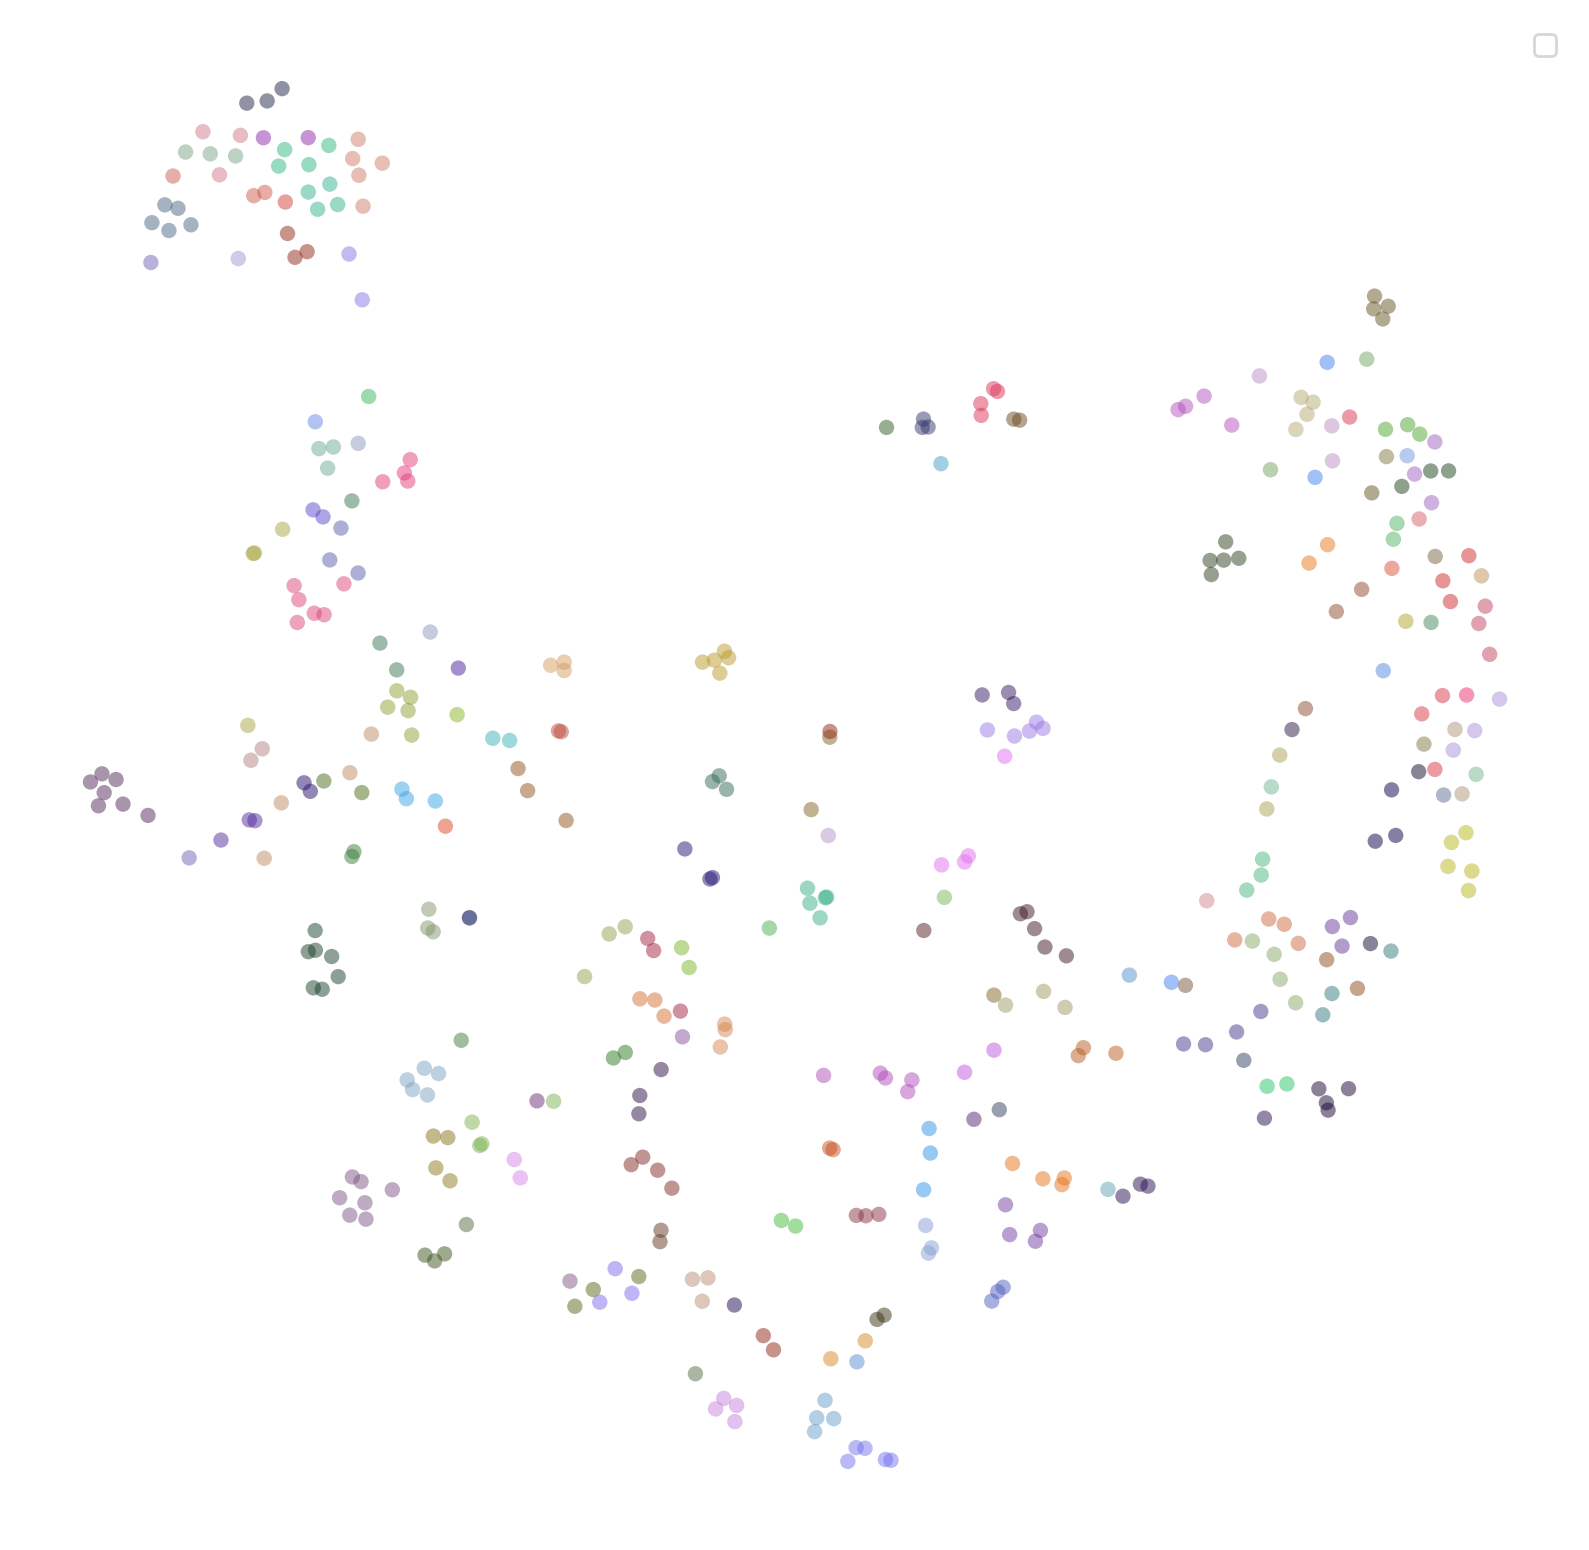

In [13]:
import matplotlib.pyplot as plt

d1 = ["#572023","#4ebd32","#4a219c","#89b925","#753ec2","#28c769","#be59e0","#4ea530","#7f6df3","#c2b41d","#261374","#4ab252","#b651c0","#75ba56","#5256c5","#e6a01e","#8479e6","#8da435","#693a99","#2e7c23","#ee2e6f","#51b469","#2a0f52","#bd9c2a","#5488e3","#eb791c","#5790d3","#e04723","#38b5bc","#de364f","#49b87f","#de477a","#38b18b","#d74236","#4bb9a6","#a72544","#3e7e3c","#ca83de","#84a550","#4e2875","#da8829","#5e60af","#c5a54b","#150830","#db8c43","#38417b","#ba5d1f","#46a1cc","#8e2615","#5fa5b9","#d16a43","#1e2647","#d59e60","#2d1946","#87ab69","#89529a","#586b19","#ac91da","#917a1e","#88a1d6","#8f4d1b","#556497","#d98955","#324260","#aea257","#522d5a","#74b790","#d76166","#448958","#cf6589","#1c451d","#d96c7e","#1c432c","#d05d50","#57988c","#7c2e24","#7ea78b","#431626","#b6ac74","#7e5686","#3e571d","#ba8fc2","#846625","#9199be","#3a3415","#d1868e","#3c7659","#8d3a4e","#276361","#d17e68","#4a6785","#c18c63","#596e46","#b68285","#6d4920","#9ea67e","#673a27","#c18f77","#827b46","#7a6447"]
d2 = ["#904d2f","#975deb","#47bd3b","#381793","#7cb827","#8c29ae","#bab71b","#594bcc","#559829","#e56ef1","#3db960","#b65ada","#7eb453","#532c9e","#b0a42b","#7673f1","#d99227","#280f6f","#31ba7f","#b24dbc","#4c6f1c","#4483f2","#e9751b","#3295e9","#e54021","#3ba7e5","#d3282c","#36b393","#e63d7a","#56a06c","#0f0047","#aba745","#1c0b53","#72a662","#7441a4","#867718","#9b7ae5","#98a051","#5061c2","#cb5021","#6889e5","#d37334","#423b8d","#cb8e3f","#381c64","#be9353","#180632","#e07c52","#3566aa","#dc533e","#3eadc8","#dc3748","#52b4b6","#de365a","#335f26","#d686ea","#30401f","#9e65c3","#a39b64","#301146","#6cab96","#912917","#6e98de","#92541d","#a492e5","#675623","#7565b4","#83976d","#6d307b","#356c58","#c64461","#347b81","#ec726b","#0e0d2c","#d19471","#231a40","#bd4c41","#67a0cf","#822a29","#7ea5c4","#290211","#c386d2","#53221d","#9e9bd6","#3f1926","#b597c6","#242d4b","#d2786f","#343a71","#af9677","#522d5a","#d4798b","#344b69","#8a354a","#436393","#79573e","#8164a3","#b68285","#5c7090","#825989"]
colors = list(set(d1 + d2))
faceColors = [colors[int(label)] for label in trackletLabels]
# colors = get_cmap(155)
# faceColors = [colors(int(label)) for label in predictions]
plt.rcParams["figure.figsize"] = (10, 10)
fig, ax = plt.subplots(1, dpi=200)
plt.scatter(reduction[1:][:, 0], reduction[1:][:, 1], s=30, alpha=0.5, edgecolor="#262626", linewidth=0.02, facecolor=faceColors)
# Viz tweaks https://olgabotvinnik.com/blog/prettyplotlib-painlessly-create-beautiful-matplotlib
[ax.spines[spine].set_visible(False) for spine in ["top", "right", "bottom", "left"]]
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
ax.axis("tight")
ax.legend()
plt.show()

In [ ]:
# TODOs
# [1] Support triplets
# [2] Top N accuracy
# [3] Incorporate Test set tracklets
# [4] Train on first few week, see how it performs on the next few.